In [3]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat

%matplotlib inline

# Setup

In [4]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
# DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
# if GPUS:
#     try:
#         for gpu in GPUS:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# else:
#     DEVICE = '/CPU:0'
DEVICE = '/CPU:0'

tf.keras.backend.set_floatx('float64')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Running on device: {}".format(DEVICE))

TensorFlow version: 2.5.0
Eager execution: True
Num GPUs available: 2
Running on device: /CPU:0


# Load model and data

In [5]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/pendulum_2021-09-07-1846/epoch_700_loss_-3.49'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load evenly spaced rings for test trajectories (from Lusch et al 2018)
rings = np.loadtxt('PendulumRings.csv', delimiter=',')
test_data = rings.reshape((rings.shape[0], int(rings.shape[1]/2), 2))
test_data = tf.cast(test_data, dtype=hyp_params['precision'])
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (10, 1500, 2)


In [11]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['num_pred_steps'] = test_data.shape[1]
hyp_params['time_final'] = hyp_params['num_time_steps'] * hyp_params['delta_t']
hyp_params['pretrain'] = False

# Just examine 1 batch for now
test_data = test_data[:hyp_params['batch_size'], :, :]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
# model.build(input_shape=test_data.shape)
model(test_data[:hyp_params['batch_size'], :, :])
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  1500


# Run the trained model

In [12]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

[y, x_ae, x_adv, y_adv, y_adv_imag, weights, Lam, Phi, b] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.9171606
Log10 Loss: -0.0375546


# Visualize results

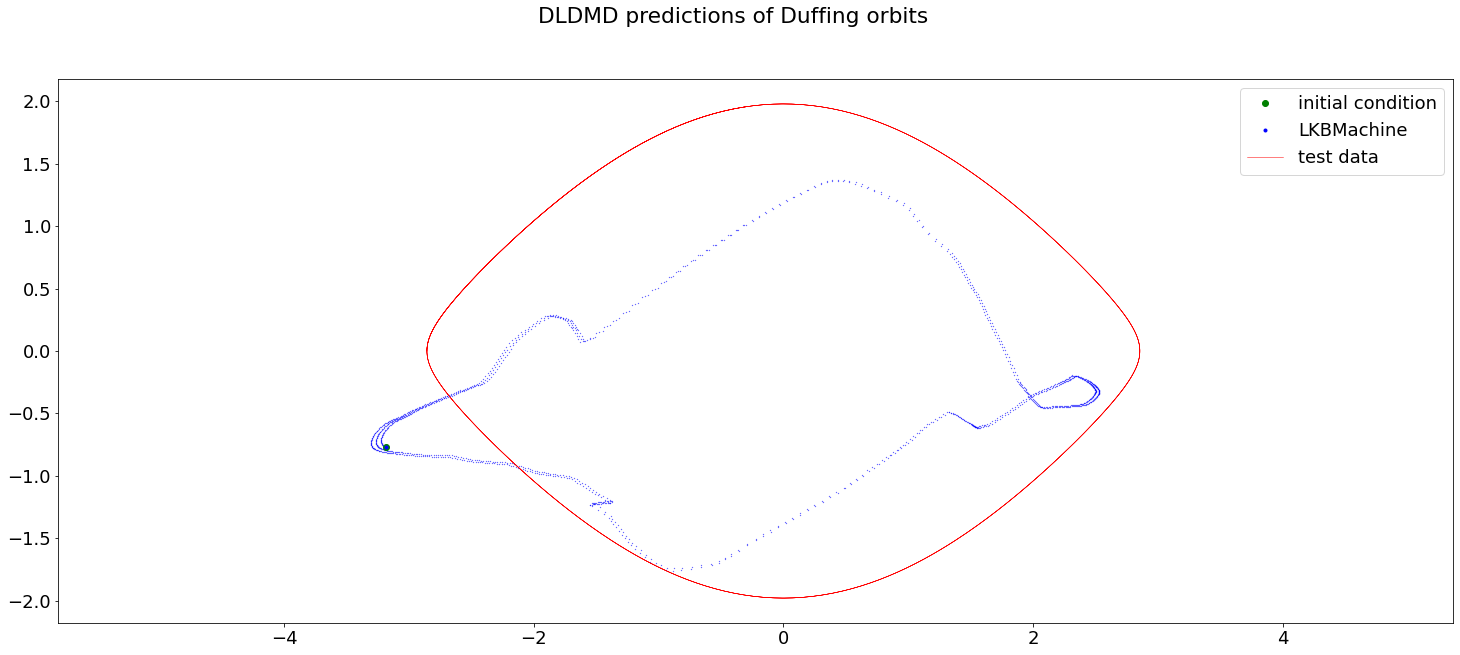

In [13]:
skip = 10

fig = plt.figure(3141, figsize=(25,10))
ax1 = plt.subplot(1, 1, 1)
for ii in range(0, test_data.shape[0], skip):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax1.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], 'b.', ms=0.5)
ax1.plot(x_adv[::10, 0, 0], x_adv[::10, 0, 1], 'go', label='initial condition')
ax1.plot(x_adv[0, 0, 0], x_adv[0, 0, 1], 'b.', label='LKBMachine')
ax1.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax1.legend()
ax1.axis('equal')
plt.suptitle("DLDMD predictions of Duffing orbits")
plt.show()

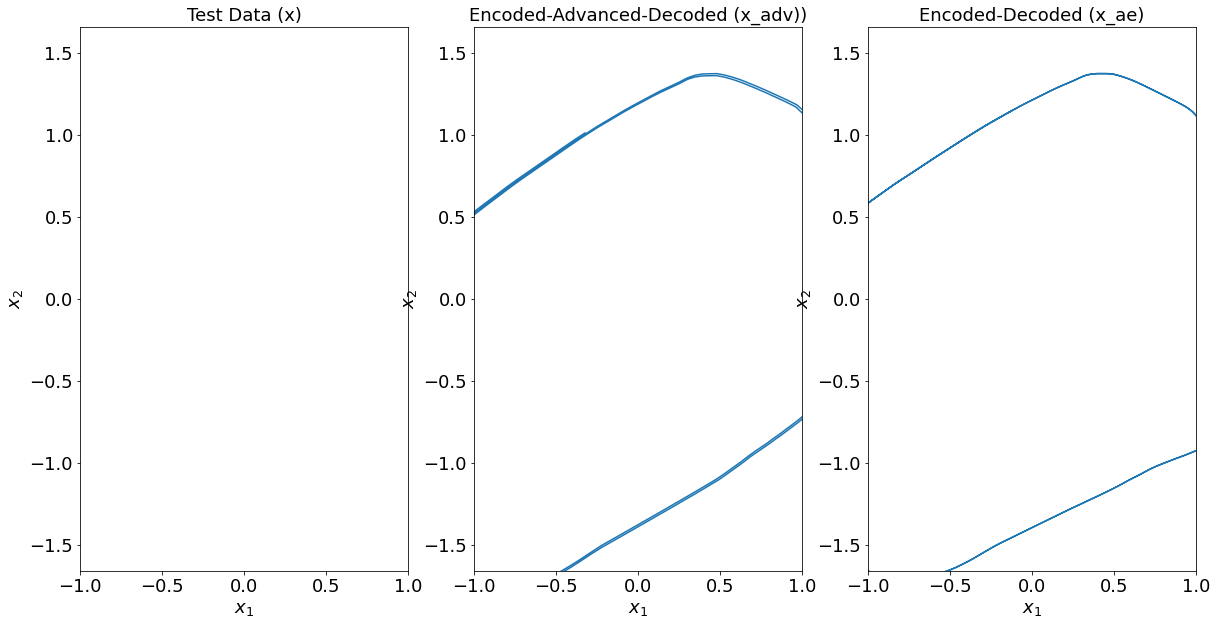

In [14]:
skip = 10

fig = plt.figure(1, figsize=(20,10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
for ii in range(0, test_data.shape[0], skip):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], '-')
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], '-')
    ax3.plot(x_ae[ii, :, 0], x_ae[ii, :, 1], '-')
ax1.plot(test_data[::skip, 0, 0], test_data[::skip, 0, 1], 'go')
ax2.plot(x_adv[::skip, 0, 0], x_adv[::skip, 0, 1], 'go')
ax3.plot(x_ae[::skip, 0, 0], x_ae[::skip, 0, 1], 'go')
ax1.axis('equal')
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_xlabel("$x_1$", fontsize=fontsize)
ax1.set_ylabel("$x_2$", fontsize=fontsize)
ax1.set_title("Test Data (x)", fontsize=fontsize)
ax2.axis('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_xlabel("$x_1$", fontsize=fontsize)
ax2.set_ylabel("$x_2$", fontsize=fontsize)
ax2.set_title("Encoded-Advanced-Decoded (x_adv))", fontsize=fontsize)
ax3.axis('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_xlabel("$x_1$", fontsize=fontsize)
ax3.set_ylabel("$x_2$", fontsize=fontsize)
ax3.set_title("Encoded-Decoded (x_ae)", fontsize=fontsize)

plt.show()

In [ ]:
ic = 1

fig = plt.figure(1, figsize=(20, 20))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)
# Plot the test trajectory components
ax1.plot(test_data[ic, :, 0], 'r-')
ax1.plot(test_data[ic, :, 1], 'b-')
ax1.set_title('Original coordinates')
# Plot the transformed trajectory components
ax2.plot(y_adv[ic, :, 0], 'c-')
ax2.plot(y_adv[ic, :, 1], 'm-')
ax2.plot(y_adv[ic, :, 2], 'y-')
ax2.set_title('Lifted coordinates')
plt.show()